## Get Started Black-box Attacks

__Description__:

This notebook demonstrates how to perform black-box attacks using HEART and MAITE

__Intended Audience__:

All T&E Users

## Contents:
1. Notebook imports
2. Load the data and model
3. Define a black-box attack
4. Visualize the adversarial images and predictions
5. Examine robustessness bias
6. Query Efficient Black-box attack
7. SignOPT Black-box attack
8. Laser Beam attack
9. Conclusions and next steps

#### 1. Notebook imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from datasets import load_dataset

from heart_library.estimators.classification.pytorch import JaticPyTorchClassifier
from heart_library.attacks.attack import JaticAttack

from heart_library.metrics import AccuracyPerturbationMetric, BlackBoxAttackQualityMetric

%matplotlib inline

#### 2. Load the dataset and model
In this notebook demonstration, we are focussing on the image-classification task:
- First load an applicable dataset for classification. In this notebook we load the XView dataset for classification
- Then load a classification model. In this notebook we select a resnet18 which has been trained on XView data

In [2]:
classes = {
    0:'Building',
    1:'Construction Site',
    2:'Engineering Vehicle',
    3:'Fishing Vessel',
    4:'Oil Tanker',
    5:'Vehicle Lot'
}

'''
Load an applicable dataset
'''
data = load_dataset("CDAO/xview-subset-classification", split="test[0:14]")

'''
Define the model
'''
model = torchvision.models.resnet18(False)
num_ftrs = model.fc.in_features 
model.fc = torch.nn.Linear(num_ftrs, len(classes.keys())) 
model.load_state_dict(torch.load('../utils/resources/models/xview_model.pt'))
_ = model.eval()

'''
Wrap the model
'''
jptc = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1),
)

'''
Transform dataset
'''
IMAGE_H, IMAGE_W = 224, 224
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize((IMAGE_H, IMAGE_W)),
    transforms.ToTensor()
])

data = data.map(lambda x: {"image": preprocess(x["image"]), "label": x["label"]})
to_image = lambda x: transforms.ToPILImage()(torch.Tensor(x))


Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

#### 3. Define a black-box attack
Black-box attacks assume that an adversary only has knowledge of the input data and access to a model for making predictions and does not have access to the underlying model architecture (e.g. the weights). In this type of attack, an adversary can use the relationship between the input data and output predictions to understand how the model works and attempt to undermine it by modifying future data passed to the model for prediction. This can be an expensive and risky attack as it requires the adversary to query the model multiple times, however it is also a much more realistic threat as many more potential adversaries will have black-box access over white-box access to a model.

- In this scenario, we demonstrate the HopSkipJump black-box attack. We first define the attack and parameters.
- We then wrap the attack using the MAITE supported `JaticAttack` class.
- We run this attack, generating adversarial examples.
- Finally, we measure the clean and robustness accuracy of the attack.

In [3]:
from heart_library.attacks.evasion import HeartHopSkipJump
'''
Define and wrap the attacks
'''
evasion_attack = HeartHopSkipJump(classifier=jptc, max_iter=10, max_eval=50, init_eval=2, init_size=500, )

attack = JaticAttack(evasion_attack, norm=2) 

'''
Generate adversarial images
'''
x_adv, y, metadata = attack(data=data)

'''
Calc clean and robust accuracy
'''
metric = AccuracyPerturbationMetric(jptc(data), metadata)
metric.update(jptc(x_adv), y)
print(metric.compute())

'''
Analyse black box attack quality 
'''
quality_metric = BlackBoxAttackQualityMetric(attack)
quality_metric.update()
quality_metrics = quality_metric.compute()

HopSkipJump:   0%|          | 0/14 [00:00<?, ?it/s]

{'clean_accuracy': 0.7857142857142857, 'robust_accuracy': 0.42857142857142855, 'mean_delta': 17.571756}


Attacker perspective
- Benign image queries: Costly, as expensive (money/computation) and not useful for attack purposes
- Adversarial image queries: Risky, as increases risk of attack detection, but at least these can be used!

Model owner perspective
- Benign image queries: Many images, similar (within distance threshold), returning same result is not suspicious (hard to detect attacker trying to approach db)
- Adversarial image queries: 
- Other notes: 
    - Many images, similar, returning many different classes (crossing decision boundary) 
    - Many different predictions (frequent crossing of decision boundary), less suspicous (? - but not within distance threshold for multiple queries?)

In [4]:
for img in range(0, 12):
    print(f"image: {img+1}")
    print("total queries:", quality_metrics["total_queries"][img])
    print(f"""adversarial queries: {(quality_metrics['adv_queries'][img] / quality_metrics["total_queries"][img])*100:.2f}%""")
    print(f"""benign queries: {(quality_metrics['benign_queries'][img] / quality_metrics["total_queries"][img])*100:.2f}%""")
    print("----")

image: 1
total queries: 501.0
adversarial queries: 0.00%
benign queries: 100.00%
----
image: 2
total queries: 501.0
adversarial queries: 0.00%
benign queries: 100.00%
----
image: 3
total queries: 501.0
adversarial queries: 0.00%
benign queries: 100.00%
----
image: 4
total queries: 501.0
adversarial queries: 0.00%
benign queries: 100.00%
----
image: 5
total queries: 501.0
adversarial queries: 0.00%
benign queries: 100.00%
----
image: 6
total queries: 501.0
adversarial queries: 0.00%
benign queries: 100.00%
----
image: 7
total queries: 501.0
adversarial queries: 0.00%
benign queries: 100.00%
----
image: 8
total queries: 501.0
adversarial queries: 0.00%
benign queries: 100.00%
----
image: 9
total queries: 223.0
adversarial queries: 48.43%
benign queries: 51.57%
----
image: 10
total queries: 223.0
adversarial queries: 42.60%
benign queries: 57.40%
----
image: 11
total queries: 501.0
adversarial queries: 0.00%
benign queries: 100.00%
----
image: 12
total queries: 250.0
adversarial queries: 

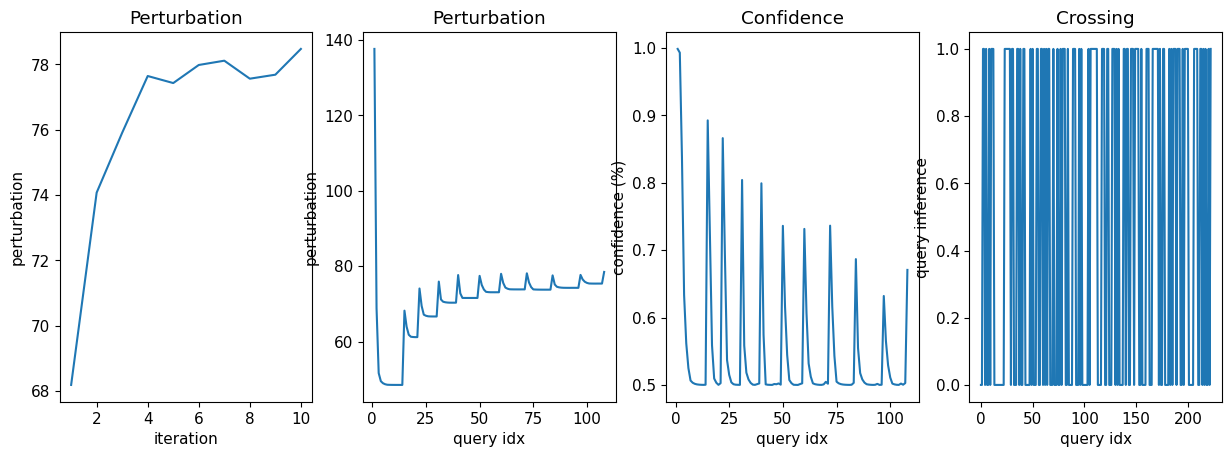

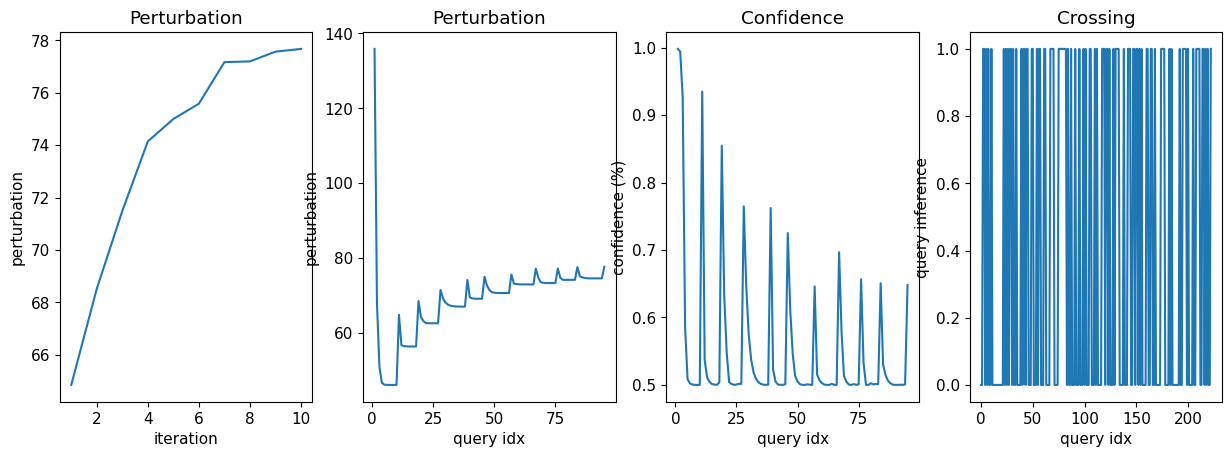

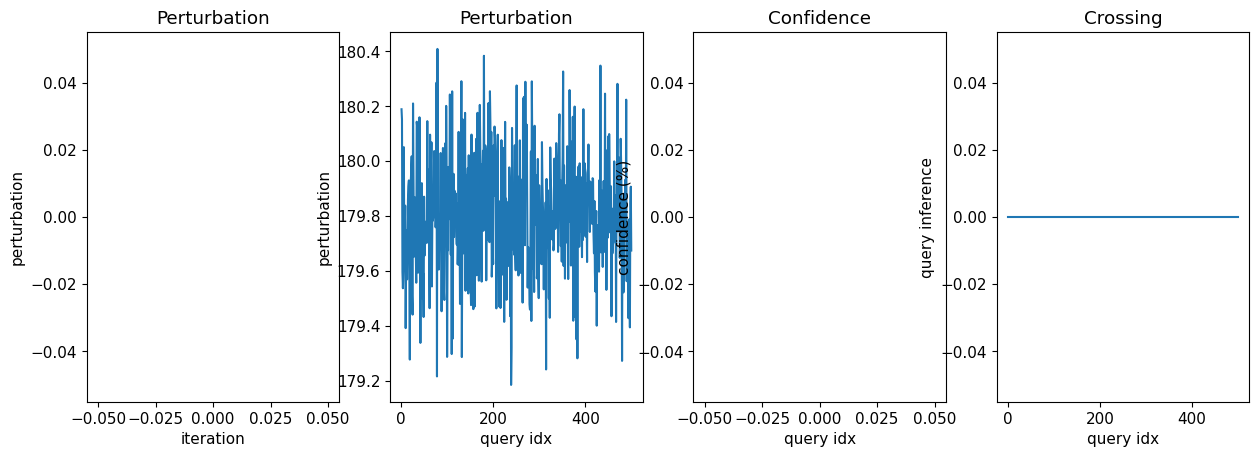

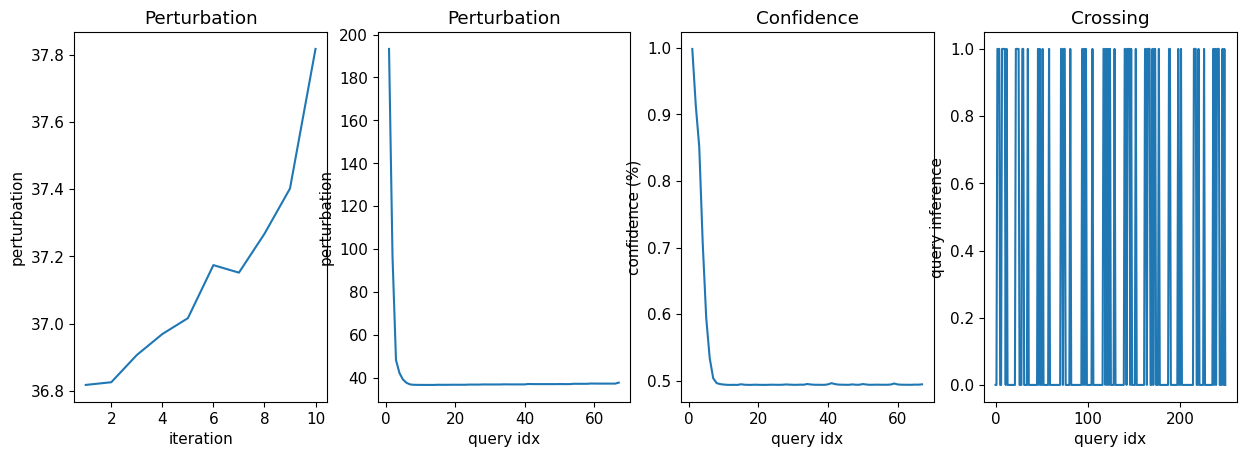

In [5]:
for img in range(8,12):
    f, ax = plt.subplots(1,4)
    f.set_figwidth(15)
    
    xlim = (0, 10) # (10, 100) 
    ylim = (34.5, 38.5)
    
    x = list(range(1, len(quality_metrics["adv_perturb_iter"][img])+1))
    y = quality_metrics["adv_perturb_iter"][img]
    ax[0].plot(x, y,)
    ax[0].set_title('Perturbation')
    ax[0].set_xlabel('iteration')
    ax[0].set_ylabel('perturbation')
    
    x = list(range(1, len(quality_metrics["adv_perturb_total"][img])+1))
    y = quality_metrics["adv_perturb_total"][img]
    ax[1].plot(x, y,)
    ax[1].set_title('Perturbation')
    ax[1].set_xlabel('query idx')
    ax[1].set_ylabel('perturbation')

    x = list(range(1, len(quality_metrics["adv_confs_total"][img])+1))
    y = quality_metrics["adv_confs_total"][img]
    ax[2].plot(x, y,)
    ax[2].set_title('Confidence')
    ax[2].set_xlabel('query idx')
    ax[2].set_ylabel('confidence (%)')
    
    x = list(range(int(quality_metrics["total_queries"][img])))
    y = [1 if i in quality_metrics["adv_query_idx"][img] else 0 for i in range(int(quality_metrics["total_queries"][img]))]
    ax[3].plot(x, y,)
    ax[3].set_title('Crossing')
    ax[3].set_xlabel('query idx')
    ax[3].set_ylabel('query inference')
    
    plt.show()

Attacker perspective
- Benign image queries: Costly, as expensive (money/computation) and not useful for attack purposes
- Adversarial image queries: Risky, as increases risk of attack detection, but at least these can be used!

Model owner perspective
- Benign image queries: Many images, similar (within distance threshold), returning same result is not suspicious (hard to detect attacker trying to approach db)
- Adversarial image queries: 
- Other notes: 
    - Many images, similar, returning many different classes (crossing decision boundary) 
    - Many different predictions (frequent crossing of decision boundary), less suspicous (? - but not within distance threshold for multiple queries?)

__Open questions__
- extending to existing families of black-box attacks with minimal code changes
    - decorator on the estimator
    - further investigation when transposing to open-source ART

#### 4. Visualize the adversarial images and predictions
Here we visualize the clean and adversarial images as well as the model predictions

Note: the amount of perturbation added is noted for each adversarial image

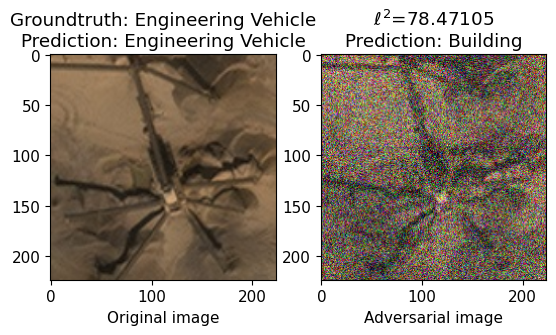

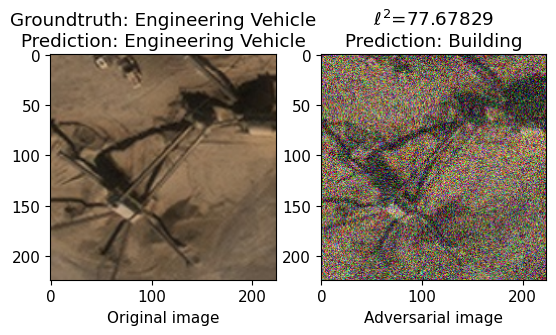

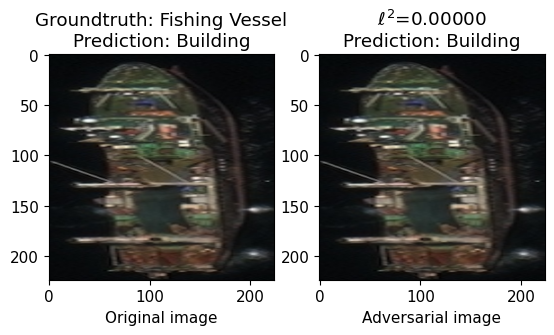

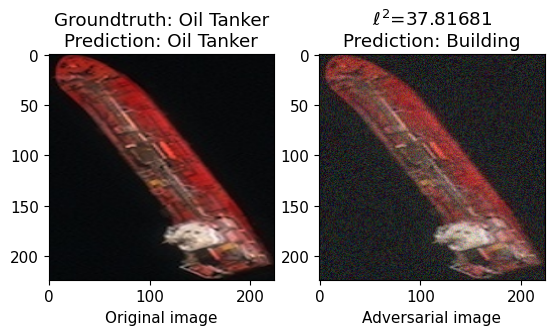

In [6]:
original_preds = jptc(data)

for i in range(8,12):
    f, ax = plt.subplots(1,2)
    
    original_prediction = classes[np.argmax(original_preds[i])]
    adv_prediction = classes[np.argmax(jptc(x_adv[[i]]))]
    
    orig_image = (np.asarray(data[i]["image"])).astype(np.float32)
    perturbation = np.linalg.norm(orig_image - x_adv[i])

    ax[0].set_title(f'Groundtruth: {classes[data[i]["label"]]}\nPrediction: {original_prediction}')
    ax[0].imshow(orig_image.transpose(1,2,0))
    ax[0].set_xlabel('Original image')

    ax[1].set_title(f'$\\ell ^{2}$={perturbation:.5f}\nPrediction: {adv_prediction}')
    ax[1].imshow(x_adv[i].transpose(1,2,0))
    ax[1].set_xlabel('Adversarial image')
    plt.show()

#### 5. Examine robustessness bias
By studying the images above, it's clear that in order to successfully attack certain types of class, a greater amount of noise had to be added to the image, thus increasing the chances of detecting the attack. To quantify the robustness bias and identify which classes are more susceptible to attack, we use the `RobustnessBiasMetric`.

The graph indicates that Engineering Vehicles (blue line) are less susceptible to adversarial attack than Vehicle Lots (green line) as at 𝛕 = 40, all Vehicle Lot images are successfully attacked, whilst no Engineering Vehicles are successfully attacked.

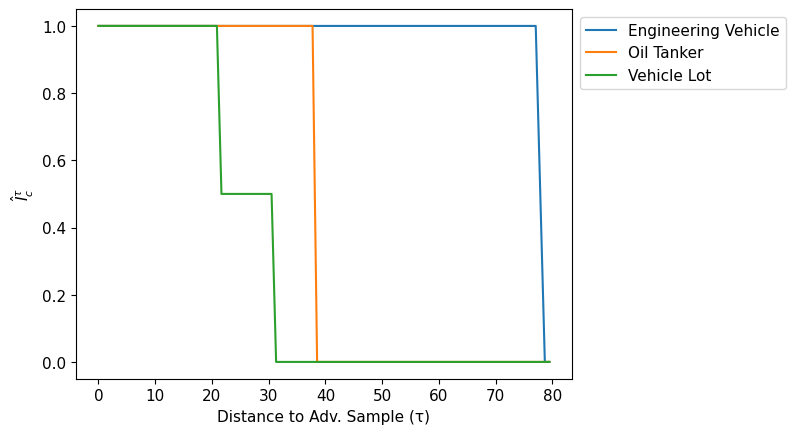

In [7]:
from heart_library.metrics import RobustnessBiasMetric

labels = np.array(list(classes.values()))
benign_preds = jptc(data)

rbm = RobustnessBiasMetric(metadata, labels)
rbm.update(jptc(x_adv), benign_preds)
series = rbm.compute()

'''
Plot the robustness bias
'''
import pandas as pd
final = pd.DataFrame()
for label in list(series.keys()):
    tmp = pd.DataFrame(series[label], columns=['x', 'y'])
    tmp['label'] = classes[label]
    final = pd.concat([final, tmp])

df = final.pivot(index='x', columns='label', values='y')

ax = df.plot()
plt.xlabel('Distance to Adv. Sample (τ)')
plt.ylabel(r"""$\^I_c^τ$""")
ax.legend(bbox_to_anchor=(1.0, 1.0))

### 6. SignOPT Black-box attack
For this black box attack, the classification model must output class probability as opposed to logits, therefore we are adding a Softmax layer to our Resnet50 model.

We import the QueryEfficientBlackBoxAttack and wrap in the JaticAttack class which adheres to MAITE protocols

In [9]:
from art.attacks.evasion import SignOPTAttack
'''
Define and wrap the attacks
'''
evasion_attack = SignOPTAttack(
    estimator=jptc, max_iter=1, num_trial=1, targeted=False, query_limit=1, k=1, 
)

attack = JaticAttack(evasion_attack, norm=2)

'''
Generate adversarial images
'''
x_adv, y, metadata = attack(data=data)

'''
Calc clean and robust accuracy
'''
metric = AccuracyPerturbationMetric(jptc(data), metadata)
metric.update(jptc(x_adv), y)
print(metric.compute())

{'clean_accuracy': 0.7857142857142857, 'robust_accuracy': 0.5, 'mean_delta': 12.015142}


We then calculate the clean and robust accuracy of the model and visualize the results

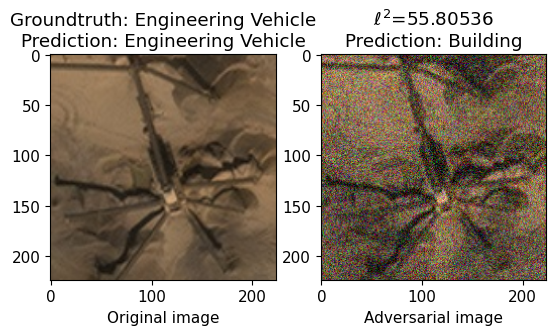

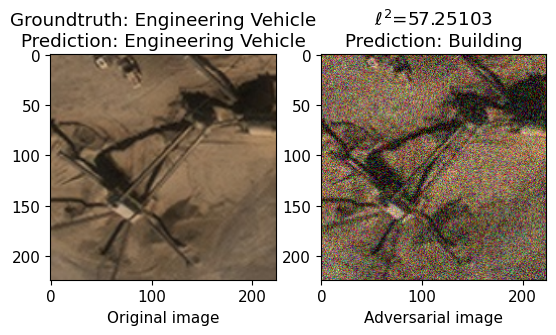

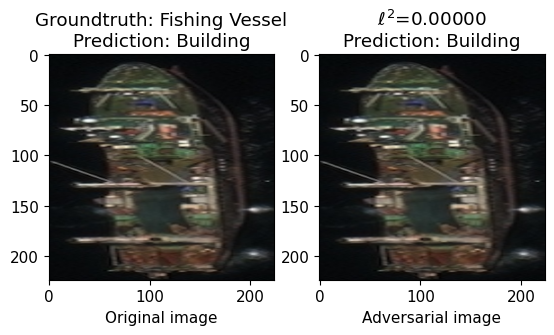

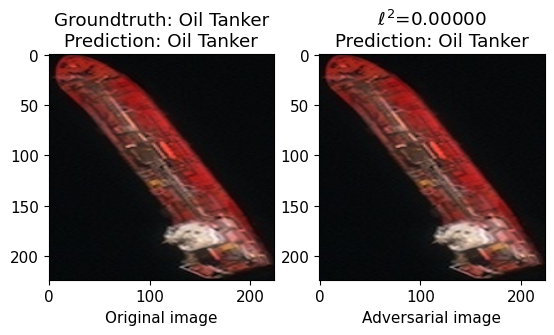

In [10]:
original_preds = jptc(data)

for i in range(8,12):
    f, ax = plt.subplots(1,2)
    
    original_prediction = classes[np.argmax(original_preds[i])]
    adv_prediction = classes[np.argmax(jptc(x_adv[[i]]))]
    
    orig_image = (np.asarray(data[i]["image"])).astype(np.float32)
    perturbation = np.linalg.norm(orig_image - x_adv[i])

    ax[0].set_title(f'Groundtruth: {classes[data["label"][i]]}\nPrediction: {original_prediction}')
    ax[0].imshow(orig_image.transpose(1,2,0))
    ax[0].set_xlabel('Original image')

    ax[1].set_title(f'$\\ell ^{2}$={perturbation:.5f}\nPrediction: {adv_prediction}')
    ax[1].imshow(x_adv[i].transpose(1,2,0))
    ax[1].set_xlabel('Adversarial image')
    plt.show()

### 7. Query Efficient Black-box attack
For this black box attack, the classification model must output class probability as opposed to logits, therefore we are adding a Softmax layer to our Resnet50 model.

In [11]:
model.fc = torch.nn.Sequential(
    model.fc,
    torch.nn.Softmax(),
)
jptc = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1),
)

We import the QueryEfficientBlackBoxAttack and wrap in the JaticAttack class which adheres to MAITE protocols

In [12]:
from heart_library.attacks.evasion.query_efficient_bb_attack import HeartQueryEfficientBlackBoxAttack

query_attack = HeartQueryEfficientBlackBoxAttack(estimator=jptc, eps=0.2)
attack = JaticAttack(query_attack, norm=2)

x_adv, y, metadata = attack(data)

We then calculate the clean and robust accuracy of the model and visualize the results

Note: the amount of perturbation added is noted for each adversarial image

{'clean_accuracy': 0.7857142857142857, 'robust_accuracy': 0.5, 'mean_delta': 71.74425}


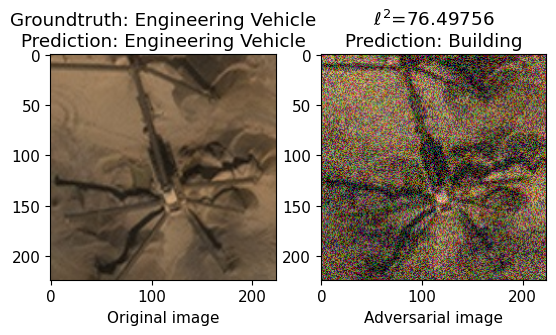

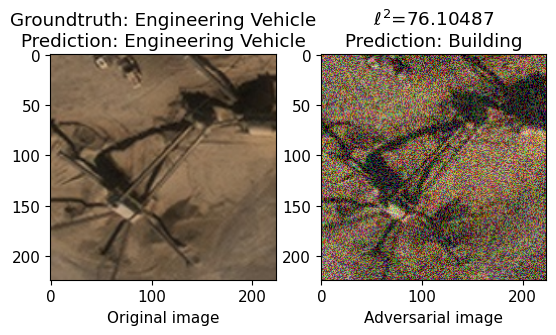

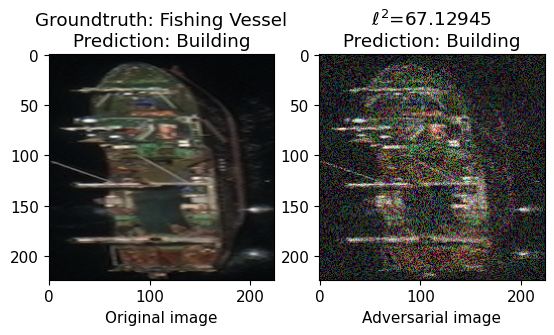

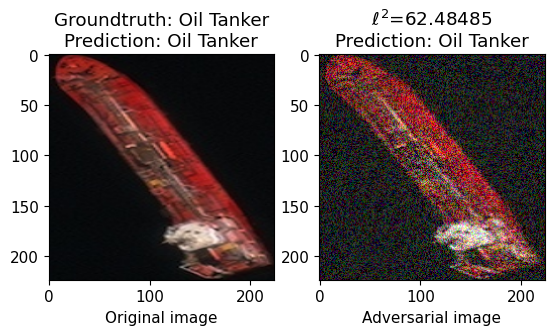

In [13]:
'''
Calc clean and robust accuracy
'''
metric = AccuracyPerturbationMetric(jptc(data), metadata)
metric.update(jptc(x_adv), y)
print(metric.compute())

original_preds = jptc(data)

for i in range(8,12):
    f, ax = plt.subplots(1,2)
    
    original_prediction = classes[np.argmax(original_preds[i])]
    adv_prediction = classes[np.argmax(jptc(x_adv[[i]]))]
    
    orig_image = (np.asarray(data[i]["image"])).astype(np.float32)
    perturbation = np.linalg.norm(orig_image - x_adv[i])

    ax[0].set_title(f'Groundtruth: {classes[data["label"][i]]}\nPrediction: {original_prediction}')
    ax[0].imshow(orig_image.transpose(1,2,0))
    ax[0].set_xlabel('Original image')

    ax[1].set_title(f'$\\ell ^{2}$={perturbation:.5f}\nPrediction: {adv_prediction}')
    ax[1].imshow(x_adv[i].transpose(1,2,0))
    ax[1].set_xlabel('Adversarial image')
    plt.show()

#### 8. Laser Beam Attack

Get a subset of images of different classes

In [14]:
sub_data = torch.utils.data.Subset(data, [0, 8, 11, 13])

Define the LaserBeam attack, wrap in HEART attack class and execute, tracking metrics for clean and robust accuracy

In [15]:
from heart_library.attacks.attack import JaticAttack
from heart_library.attacks.evasion import HeartLaserBeamAttack
'''
Define and wrap the attacks
'''
laser_attack = HeartLaserBeamAttack(jptc, 5, max_laser_beam=(580, 3.14, 100, 100), random_initializations=10)

attack = JaticAttack(laser_attack, norm=2)

'''
Generate adversarial images
'''
x_adv, y, metadata = attack(data=sub_data)

'''
Calc clean and robust accuracy
'''
metric = AccuracyPerturbationMetric(jptc(sub_data), metadata)
metric.update(jptc(x_adv), y)
print(metric.compute())

{'clean_accuracy': 1.0, 'robust_accuracy': 0.0, 'mean_delta': 88.71944}


 Visualize the results of the LaserBeam attack

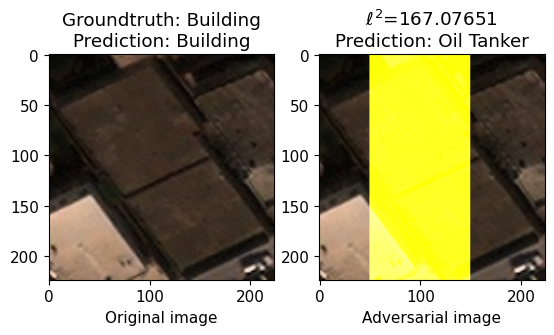

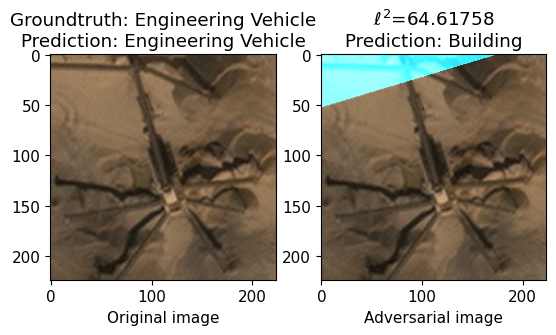

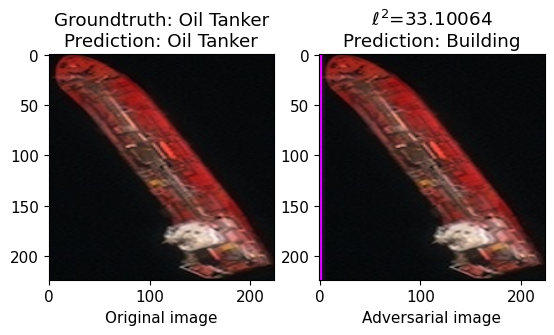

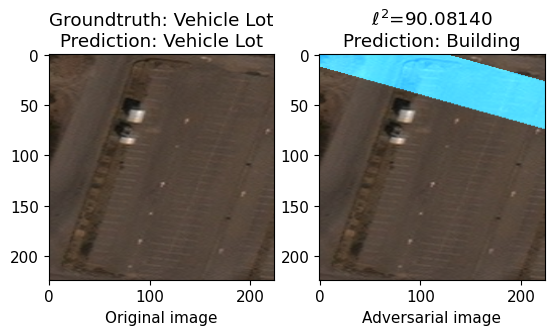

In [16]:
original_preds = jptc(sub_data)

for i in range(len(sub_data)):
    f, ax = plt.subplots(1,2)
    
    original_prediction = classes[np.argmax(original_preds[i])]
    adv_prediction = classes[np.argmax(jptc(x_adv[[i]]))]
    
    orig_image = (np.asarray(sub_data[i]["image"])).astype(np.float32)
    perturbation = np.linalg.norm(orig_image - x_adv[i])

    ax[0].set_title(f'Groundtruth: {classes[sub_data[i]["label"]]}\nPrediction: {original_prediction}')
    ax[0].imshow(orig_image.transpose(1,2,0))
    ax[0].set_xlabel('Original image')

    ax[1].set_title(f'$\\ell ^{2}$={perturbation:.5f}\nPrediction: {adv_prediction}')
    ax[1].imshow(x_adv[i].transpose(1,2,0))
    ax[1].set_xlabel('Adversarial image')
    plt.show()

#### Laser beam support for single channel (black/white) images

In [17]:
from art.attacks.evasion.laser_attack.utils import ImageGenerator
from typing import Callable, Tuple

class MyImageGen(ImageGenerator):
    
    def generate_image(self, adv_object: Callable, shape: Tuple) -> np.ndarray:
        """
        Generate image of the adversarial object.

        :param adv_object: Adversarial object.
        :param shape: Shape of the desired image.
        :returns: Image of the adversarial object.
        """
        laser_image = np.zeros(shape)
        
                    
        if laser_image.ndim == 3 and laser_image.shape[2] == 1:
            for i in range(shape[0]):
                for j in range(shape[1]):
                    '''rgb = adv_object(i, j)
                    laser_image[i, j, 0] = np.dot(rgb[..., :3], [0.299, 0.587, 0.114])'''
                    rgb = np.mean(adv_object(i, j))
                    laser_image[i, j, 0] = np.clip(rgb, 0, 1)
        else:
            raise ValueError("Incorrect laser shape")

        return laser_image

/Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/env/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for mnist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mnist
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Couldn't find adversarial laser parameters


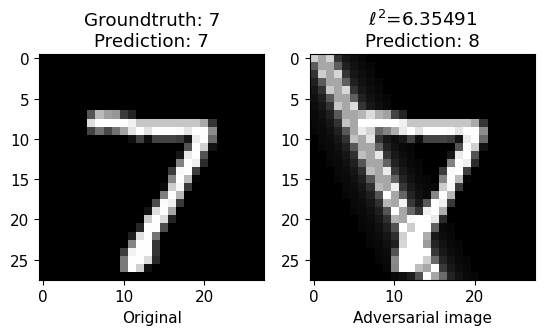

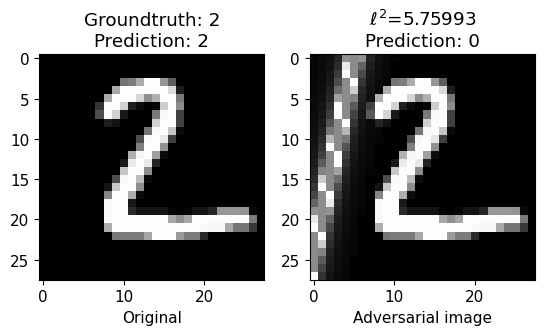

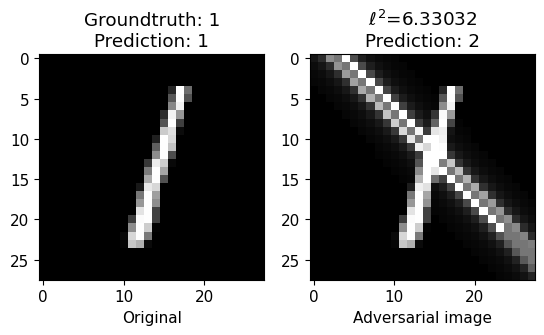

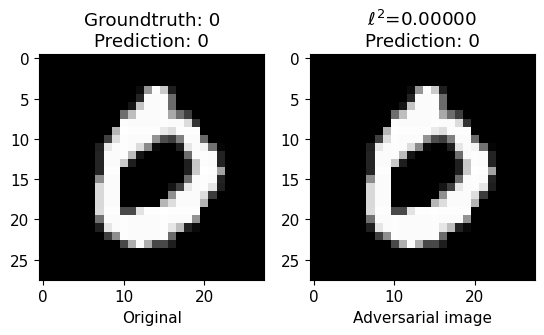

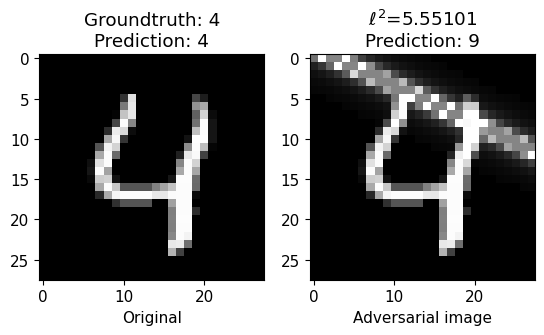

In [18]:
data = load_dataset("mnist", split="test[0:5]")
labels = list(range(10))

preprocess = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor()
])

data = data.map(lambda x: {"image": preprocess(x["image"]), "label": x["label"]})
to_image = lambda x: transforms.ToPILImage()(torch.Tensor(x))


loss_fn = torch.nn.CrossEntropyLoss()

jptc = JaticPyTorchClassifier(
    model='fxmarty/resnet-tiny-mnist', loss=loss_fn, input_shape=(1, 28, 28), nb_classes=10, clip_values=(0, 1),
    provider="huggingface", preprocessing=([0.45], [0.22]),
)

evasion_attack = HeartLaserBeamAttack(jptc, 10, max_laser_beam=(480, 3.18, 5, 1), random_initializations=10, image_generator=MyImageGen())
attack = JaticAttack(evasion_attack, norm=2)

x_adv, y, metadata = attack(data=data)

preds = jptc(data)
pred_adv = jptc(x_adv)

for i in range(5):
    f, ax = plt.subplots(1,2)
    norm_orig_img = np.asarray(data.__getitem__(i)["image"]).astype(np.float32)
    perturbation = np.linalg.norm(norm_orig_img - x_adv[i])

    ax[0].set_title(f'Groundtruth: {labels[data.__getitem__(i)["label"]]}\nPrediction: {labels[np.argmax(preds[i])]}')
    ax[0].imshow(norm_orig_img.transpose(1,2,0), cmap="gray")
    ax[0].set_xlabel('Original')

    ax[1].set_title(f'$\\ell ^{2}$={perturbation:.5f}\nPrediction: {labels[np.argmax(pred_adv[i])]}')
    ax[1].imshow(x_adv[i].transpose(1,2,0), cmap="gray")
    ax[1].set_xlabel('Adversarial image')
    plt.show()

#### 9. Conclusions and next steps
- This notebook demonstrated a black-box attack for an image-classification task using XView and Resnet18
- Modify this notebook by swapping in your own dataset and classification model
- Try out additional black-box attacks to better understand the resilience of your model to this threat 
- Ascertain realitic attacker budgets (number of queries sent to the model) that are successful for your model and dataset
- Consolidate all findings into a model card for reporting